In [1]:
from qiskit import *
from qiskit.quantum_info import SparsePauliOp
from scipy.optimize import minimize
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
import numpy as np, random, matplotlib.pyplot as plt

plt.style.use(['science', 'notebook', 'grid', 'dark_background'])

KeyboardInterrupt: 

The *Variational Quantum Eigensolver* (VQE) is a hybrid quantum-classical algorithm that finds the **ground state energy** of a given molecule, and is essentially, an **Optimization Algoithm.** In this notebook, we will use the VQE algorithm to find the ground state Hamiltonian of the hydrogen molecule.

In summary, we have to

1. Define the Hamiltonian of the molecule,
2. Find the lowest state to use as a reference, 
3. Define the Ansatz,
4. Define the Circuit and the Quantum Backend,
5. Measure on the Quantum Computer,
6. Define the Expectation Values from those measurements,
7. Run the optimizer, and find the lowest eigenenergy to compare with the reference value.

# Step 1 - Define the Hamiltonian of the molecule:

We'll start with the *Ansatze,* or Ansatz in English, which is a parameterized quantum circuit that prepares a trial wavefunction. We'll first define the Hamiltonian or the hydrogen molecule though, as a linear sum of the Pauli Spin Matrices:

In [ ]:
a = 10 * random.random()
b = 10 * random.random()
c = 10 * random.random()
d = 10 * random.random()

hamiltonian = SparsePauliOp.from_list([("I", a), ("Z", b), ("X", c), ("Y", d)]) 
hamiltonian.to_matrix()

array([[10.68943004+0.j        ,  1.37122664-1.17552629j],
       [ 1.37122664+1.17552629j, -5.45837075+0.j        ]])

# Step 2 - Find the lowest state to use as a reference:

In [ ]:
min_hamiltonian = NumPyMinimumEigensolver().compute_minimum_eigenvalue(hamiltonian)
min_hamiltonian.eigenvalue.real

-5.657921397082583

# Step 3 - Define the Ansatz:

In [ ]:
params = np.array([np.pi, np.pi, np.pi])
def ansatz_prep(circuit, params):
    q = circuit.qregs[0]
    circuit.rx(params[0], q[0])
    circuit.ry(params[1], q[0])
    circuit.rz(params[2], q[0])

    return circuit

# Step 4 - Define the Circuit and the Quantum Backend:

In [ ]:
def vqe_circuit(params, op):
    q = QuantumRegister(1)
    c = ClassicalRegister(1)

    circuit = QuantumCircuit(q, c)
    ansatz_prep(circuit, params)

    if op == 'Z':
        circuit.measure(q[0], c[0])
    elif op == 'X':
        circuit.h(q[0])
        circuit.measure(q[0], c[0])
    elif op == 'Y':
        circuit.sdg(q[0])
        circuit.h(q[0])
        circuit.measure(q[0], c[0])

    return circuit

# Step 5 and 6 - Measure on the Quantum Computer, and define the Expectation Values from those measurements:

In [ ]:
def expectation_value(counts, shots):
    exp_val = 0.0
    
    for ct in counts:
        sign  = +1
        if ct == "1":
            sign = -1
        exp_val += sign * counts[ct] / shots
    
    return exp_val

def quantum_term(params, ops):
    if ops == "I":
        return 1
    
    elif ops == "Z":
        circuit = vqe_circuit(params, ops)
        
    elif ops == "X":
        circuit = vqe_circuit(params, ops)
    
    elif ops == "Y":
        circuit = vqe_circuit(params, ops)
        
    shots = 8192
    backend = BasicAer.get_backend('qasm_simulator')
    job = execute(circuit, backend, shots = shots)
    result = job.result()
    counts = result.get_counts()
    
    return expectation_value(counts, shots)

# Step 7 - Run the optimizer, and find the lowest eigenenergy to compare with the reference value:

In [ ]:
def vqe_optimizer(params):
    print(params)
    
    ls = hamiltonian.to_list()
    circuit_sum = 0

    for i in range(len(ls)):
        circuit_sum += hamiltonian.coeffs[i].real * quantum_term(params, ls[i][0])
    
    return circuit_sum

results = minimize(vqe_optimizer, params, method = "COBYLA", tol = 1e-04)

[3.14159265 3.14159265 3.14159265]


[4.14159265 3.14159265 3.14159265]
[4.14159265 4.14159265 3.14159265]
[4.14159265 4.14159265 4.14159265]
[4.9850826  4.62646803 2.91046375]
[5.16393113 5.51460362 2.48711001]
[5.34169471 4.29070947 2.80999491]
[5.65144311 4.22513795 3.19697851]
[5.79867153 4.40752554 3.11003855]
[5.52682638 3.74245495 3.23555042]
[5.22908978 3.39584152 3.43855794]
[5.8103097  3.42992053 2.96729784]
[6.26193174 3.21576946 2.98059658]
[6.35963964 3.04135346 2.52230386]
[6.13129532 3.0087883  3.03151735]
[6.47307082 2.71079979 3.24221227]
[5.88242078 3.00504128 3.00812028]
[6.11956299 3.04545074 3.15044261]
[6.21285917 2.8293674  3.23472674]
[5.99842665 3.01472689 3.15309412]
[6.20855097 3.13306798 3.14502419]
[6.14430621 2.99173993 3.1706706 ]
[6.17381466 3.00137228 3.17428059]
[6.19877734 2.99805515 3.19278528]
[6.17877845 2.9894747  3.16545172]
[6.17194253 3.02300884 3.15181023]
[6.17144358 3.04949401 3.13523165]
[6.17819074 3.05573138 3.10536304]
[6.15693166 3.04543024 3.13110485]
[6.14349599 3.065734

In [ ]:
print("Estimated eigenenergy:", results.fun)
print("Reference eigenergy", min_hamiltonian.eigenvalue.real)

Estimated eigenenergy: -5.615502487472389
Reference eigenergy -5.657921397082583


In [ ]:
def energy_expectation(x, y):
    energy = np.zeros(x.shape)
    
    for idx, thetas in enumerate(x):
        for ind, theta1 in enumerate(thetas):
            params = np.array([np.pi/2, np.pi, theta1, y[idx][ind]])
            energy[idx][ind] = vqe_optimizer(params)
    
    return energy

theta1 = np.linspace(0.0, 2 * np.pi, 20)
theta2 = np.linspace(0.0, 2 * np.pi, 20)

X, Y = np.meshgrid(theta1, theta2)
Z = energy_expectation(X, Y)

[1.57079633 3.14159265 0.         0.        ]
[1.57079633 3.14159265 0.33069396 0.        ]
[1.57079633 3.14159265 0.66138793 0.        ]
[1.57079633 3.14159265 0.99208189 0.        ]
[1.57079633 3.14159265 1.32277585 0.        ]
[1.57079633 3.14159265 1.65346982 0.        ]
[1.57079633 3.14159265 1.98416378 0.        ]
[1.57079633 3.14159265 2.31485774 0.        ]
[1.57079633 3.14159265 2.64555171 0.        ]
[1.57079633 3.14159265 2.97624567 0.        ]
[1.57079633 3.14159265 3.30693964 0.        ]
[1.57079633 3.14159265 3.6376336  0.        ]
[1.57079633 3.14159265 3.96832756 0.        ]
[1.57079633 3.14159265 4.29902153 0.        ]
[1.57079633 3.14159265 4.62971549 0.        ]
[1.57079633 3.14159265 4.96040945 0.        ]
[1.57079633 3.14159265 5.29110342 0.        ]
[1.57079633 3.14159265 5.62179738 0.        ]
[1.57079633 3.14159265 5.95249134 0.        ]
[1.57079633 3.14159265 6.28318531 0.        ]
[1.57079633 3.14159265 0.         0.33069396]
[1.57079633 3.14159265 0.33069396 

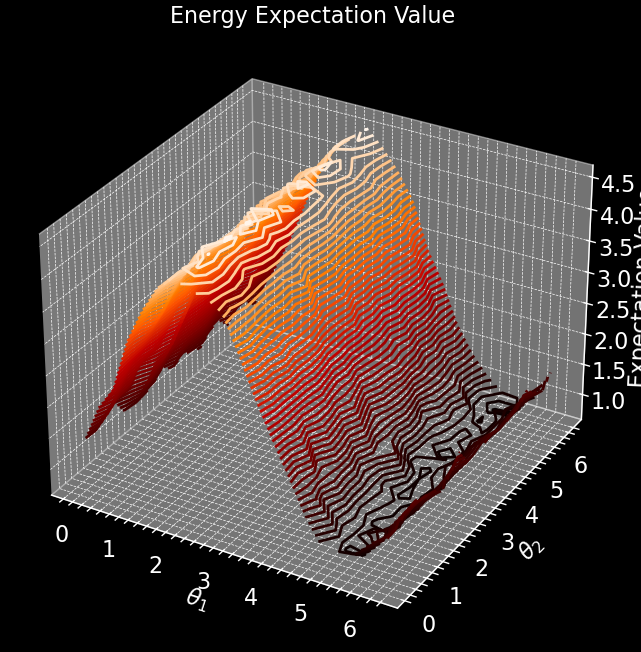

In [ ]:
%matplotlib inline

fig = plt.figure(figsize = (10, 8))
ax = plt.axes(projection = '3d')

ax.contour3D(X, Y, Z, 50, cmap = 'gist_heat')
ax.set_title('Energy Expectation Value')

ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\theta_2$')
ax.set_zlabel(r'Expectation Value');

plt.show()